#Preparando la información del dataset para su procesamiento

In [858]:
#Libraries
import pandas as pd               # For data loading
import matplotlib.pyplot as plt   # For plots 
import numpy as np                # For arrays and math

In [859]:
#Extraction
from google.colab import drive
drive.mount("/content/gdrive")  
%cd "/content/gdrive/MyDrive/Colab Notebooks/Estadística - M1"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/Estadística - M1


In [860]:
#Getting USA ticker info
df = pd.read_csv('usfirms2022.csv')
df = df[['Ticker', 'Name', 'N', 'Class','Type of Asset', 'Sector NAICS\nlevel 1']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608 entries, 0 to 3607
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Ticker                3608 non-null   object
 1   Name                  3608 non-null   object
 2   N                     3608 non-null   int64 
 3   Class                 3608 non-null   object
 4   Type of Asset         3608 non-null   object
 5   Sector NAICS
level 1  3608 non-null   object
dtypes: int64(1), object(5)
memory usage: 169.2+ KB


In [861]:
#Getting firm quarter info
df2 = pd.read_csv('us2022q2a.csv')
df2 = df2[['firm', 'q','revenue','cogs','sgae', 'otheropexp','extraincome','finexp','incometax','totalassets', 'totalliabilities', 'shortdebt', 'longdebt', 'stockholderequity', 'adjprice', 'originalprice', 'sharesoutstanding', 'fiscalmonth', 'year','cto']]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324446 entries, 0 to 324445
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   firm               324446 non-null  object 
 1   q                  324446 non-null  object 
 2   revenue            158614 non-null  float64
 3   cogs               158309 non-null  float64
 4   sgae               158309 non-null  float64
 5   otheropexp         158311 non-null  float64
 6   extraincome        158613 non-null  float64
 7   finexp             158614 non-null  float64
 8   incometax          158614 non-null  float64
 9   totalassets        159808 non-null  float64
 10  totalliabilities   159808 non-null  float64
 11  shortdebt          129677 non-null  float64
 12  longdebt           159595 non-null  float64
 13  stockholderequity  159740 non-null  float64
 14  adjprice           159154 non-null  float64
 15  originalprice      159234 non-null  float64
 16  sh

In [862]:
#Making a single DataFrame
df = pd.merge(df2,df, left_on='firm', right_on='Ticker')
df = df.drop(columns='Ticker')
df

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,originalprice,sharesoutstanding,fiscalmonth,year,cto,Name,N,Class,Type of Asset,Sector NAICS\nlevel 1
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104.0000,452000.000,NaN,2000,1,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
1,A,2000q2,2485000.0,1261000.0,1.010000e+06,0.0,42000.000000,0.000,90000.0,7321000.000,...,73.7500,452271.967,6.0,2000,2,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
2,A,2000q3,2670000.0,1369000.0,1.091000e+06,0.0,28000.000000,0.000,83000.0,7827000.000,...,48.9375,453014.579,9.0,2000,3,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
3,A,2000q4,3372000.0,1732000.0,1.182000e+06,0.0,10000.000000,0.000,163000.0,8425000.000,...,54.7500,456366.381,12.0,2000,4,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
4,A,2001q1,2841000.0,1449000.0,1.113000e+06,0.0,-6000.000000,0.000,119000.0,9208000.000,...,30.7300,456769.737,3.0,2001,1,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323811,ZYNE,2021q2,0.0,0.0,9.838494e+03,0.0,-117.528220,-5.943,0.0,98195.904,...,5.2900,41251.537,6.0,2021,2,"Zynerba Pharmaceuticals, Inc",3607,Com,Stock,Manufacturing
323812,ZYNE,2021q3,0.0,0.0,1.021065e+04,0.0,-376.636750,-5.038,0.0,89996.170,...,4.2400,41251.537,9.0,2021,3,"Zynerba Pharmaceuticals, Inc",3607,Com,Stock,Manufacturing
323813,ZYNE,2021q4,0.0,0.0,8.836436e+03,0.0,16.937906,-4.433,0.0,81171.507,...,2.8800,41217.537,12.0,2021,4,"Zynerba Pharmaceuticals, Inc",3607,Com,Stock,Manufacturing
323814,ZYNE,2022q1,0.0,0.0,8.903915e+03,0.0,317.252110,-96.044,0.0,74381.029,...,2.0500,42447.037,3.0,2022,1,"Zynerba Pharmaceuticals, Inc",3607,Com,Stock,Manufacturing


In [863]:
#Getting last 4 info of each firm
ndf = df.groupby('firm').tail(4)
ndf

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,originalprice,sharesoutstanding,fiscalmonth,year,cto,Name,N,Class,Type of Asset,Sector NAICS\nlevel 1
86,A,2021q3,1586000.0,734000.0,516000.0000,0.0,12000.000000,21000.000,63000.0,1.049100e+07,...,157.53,302722.668,9.0,2021,3,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
87,A,2021q4,1660000.0,760000.0,505000.0000,0.0,73000.000000,20000.000,6000.0,1.070500e+07,...,159.65,302000.797,12.0,2021,4,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
88,A,2022q1,1674000.0,764000.0,534000.0000,0.0,-37000.000000,20000.000,36000.0,1.032700e+07,...,132.33,300113.377,3.0,2022,1,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
89,A,2022q2,1607000.0,746000.0,501000.0000,0.0,-7000.000000,20000.000,59000.0,1.045500e+07,...,118.77,298708.056,6.0,2022,2,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
176,AA,2021q3,3109000.0,2322000.0,217000.0000,33000.0,-15000.000000,58000.000,127000.0,1.419700e+07,...,48.94,186866.156,9.0,2021,3,Alcoa Corp,127,Com,Stock,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323725,ZY,2022q2,2634.0,9732.0,58638.0000,40460.0,-885.000000,9376.000,11.0,4.709680e+05,...,1.23,103140.755,6.0,2022,2,Zymergen Inc,3606,Com,Stock,"Professional, Scientific, and Technical Services"
323812,ZYNE,2021q3,0.0,0.0,10210.6520,0.0,-376.636750,-5.038,0.0,8.999617e+04,...,4.24,41251.537,9.0,2021,3,"Zynerba Pharmaceuticals, Inc",3607,Com,Stock,Manufacturing
323813,ZYNE,2021q4,0.0,0.0,8836.4365,0.0,16.937906,-4.433,0.0,8.117151e+04,...,2.88,41217.537,12.0,2021,4,"Zynerba Pharmaceuticals, Inc",3607,Com,Stock,Manufacturing
323814,ZYNE,2022q1,0.0,0.0,8903.9150,0.0,317.252110,-96.044,0.0,7.438103e+04,...,2.05,42447.037,3.0,2022,1,"Zynerba Pharmaceuticals, Inc",3607,Com,Stock,Manufacturing


In [864]:
#Creating df1 for data that can be sum
df1 = ndf.iloc[:, 0:11]
df1

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,totalliabilities
86,A,2021q3,1586000.0,734000.0,516000.0000,0.0,12000.000000,21000.000,63000.0,1.049100e+07,5545000.000
87,A,2021q4,1660000.0,760000.0,505000.0000,0.0,73000.000000,20000.000,6000.0,1.070500e+07,5316000.000
88,A,2022q1,1674000.0,764000.0,534000.0000,0.0,-37000.000000,20000.000,36000.0,1.032700e+07,5173000.000
89,A,2022q2,1607000.0,746000.0,501000.0000,0.0,-7000.000000,20000.000,59000.0,1.045500e+07,5333000.000
176,AA,2021q3,3109000.0,2322000.0,217000.0000,33000.0,-15000.000000,58000.000,127000.0,1.419700e+07,8736000.000
...,...,...,...,...,...,...,...,...,...,...,...
323725,ZY,2022q2,2634.0,9732.0,58638.0000,40460.0,-885.000000,9376.000,11.0,4.709680e+05,234345.000
323812,ZYNE,2021q3,0.0,0.0,10210.6520,0.0,-376.636750,-5.038,0.0,8.999617e+04,11309.171
323813,ZYNE,2021q4,0.0,0.0,8836.4365,0.0,16.937906,-4.433,0.0,8.117151e+04,10258.173
323814,ZYNE,2022q1,0.0,0.0,8903.9150,0.0,317.252110,-96.044,0.0,7.438103e+04,9214.059


In [865]:
#Gettin Mean of data 
df1.groupby('firm').mean()

,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,totalliabilities
firm,,,,,,,,,
A,1631750.00,751000.00,5.140000e+05,0.00,10250.000000,20250.0000,41000.00,1.049450e+07,5.341750e+06
AA,3346500.00,2413250.00,2.232500e+05,284500.00,67750.000000,35250.0000,217250.00,1.522975e+07,8.906250e+06
AAIC,7963.75,3880.75,0.000000e+00,0.00,-2702.250000,0.0000,1083.25,9.220708e+05,7.019210e+05
AAL,10179250.00,0.00,1.040200e+07,0.00,62750.000000,457000.0000,-136500.00,6.756700e+07,7.560175e+07
AAME,48824.75,0.00,4.788075e+04,0.00,0.000000,0.0000,215.75,3.901670e+05,2.609658e+05
...,...,...,...,...,...,...,...,...,...
ZVIA,39175.50,23480.25,2.186150e+04,23648.75,12835.250000,0.0000,13.75,1.210882e+05,2.209050e+04
ZVO,57500.25,37325.75,2.795000e+04,1438.25,-995.000000,0.0000,24.50,1.352482e+05,1.150628e+05
ZWS,85075.00,48775.00,2.990000e+04,850.00,12600.000000,5500.0000,-3425.00,1.765425e+06,1.216625e+06


In [866]:
#Created dataset for data that can't be sumed
df2 = ndf[['firm','shortdebt', 'longdebt', 'stockholderequity', 'adjprice', 'originalprice', 'sharesoutstanding', 'fiscalmonth', 'year','cto','Name', 'N', 'Class','Type of Asset', 'Sector NAICS\nlevel 1']]
df2

,firm,shortdebt,longdebt,stockholderequity,adjprice,originalprice,sharesoutstanding,fiscalmonth,year,cto,Name,N,Class,Type of Asset,Sector NAICS\nlevel 1
86,A,130000.000,2728000.000,4946000.000,156.603447,157.53,302722.668,9.0,2021,3,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
87,A,0.000,2729000.000,5389000.000,158.908608,159.65,302000.797,12.0,2021,4,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
88,A,0.000,2730000.000,5154000.000,131.888962,132.33,300113.377,3.0,2022,1,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
89,A,175000.000,2730000.000,5122000.000,118.560000,118.77,298708.056,6.0,2022,2,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
176,AA,1000.000,1724000.000,5461000.000,48.597527,48.94,186866.156,9.0,2021,3,Alcoa Corp,127,Com,Stock,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323725,ZY,7900.000,178181.000,236623.000,1.230000,1.23,103140.755,6.0,2022,2,Zymergen Inc,3606,Com,Stock,"Professional, Scientific, and Technical Services"
323812,ZYNE,207.635,411.237,78686.999,4.240000,4.24,41251.537,9.0,2021,3,"Zynerba Pharmaceuticals, Inc",3607,Com,Stock,Manufacturing
323813,ZYNE,209.068,353.694,70913.334,2.880000,2.88,41217.537,12.0,2021,4,"Zynerba Pharmaceuticals, Inc",3607,Com,Stock,Manufacturing
323814,ZYNE,210.512,295.754,65166.970,2.050000,2.05,42447.037,3.0,2022,1,"Zynerba Pharmaceuticals, Inc",3607,Com,Stock,Manufacturing


In [867]:
#Getting last data of this df (2022q2)
df2 = ndf.groupby('firm').tail(1)
df2

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,originalprice,sharesoutstanding,fiscalmonth,year,cto,Name,N,Class,Type of Asset,Sector NAICS\nlevel 1
89,A,2022q2,1607000.0,746000.0,5.010000e+05,0.0,-7000.00000,20000.000,59000.0,1.045500e+07,...,118.7700,298708.056,6.0,2022,2,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
179,AA,2022q2,3644000.0,2767000.0,2.200000e+05,-75000.0,81000.00000,30000.000,234000.0,1.570900e+07,...,45.5800,184448.686,6.0,2022,2,Alcoa Corp,127,Com,Stock,Manufacturing
269,AAIC,2022q2,10900.0,6374.0,0.000000e+00,0.0,-3417.00000,0.000,802.0,1.084755e+06,...,3.2500,35016.392,6.0,2022,2,Arlington Asset Investment Corp,303,Com A,Stock,Finance and Insurance
359,AAL,2022q2,13422000.0,0.0,1.240500e+07,0.0,25000.00000,439000.000,127000.0,6.796300e+07,...,12.6800,649514.848,6.0,2022,2,American Airlines Group Inc,186,Com,Stock,Transportation and Warehousing
449,AAME,2022q2,44669.0,0.0,4.678400e+04,0.0,0.00000,0.000,-436.0,3.792740e+05,...,2.6700,20398.497,6.0,2022,2,Atlantic American Corp,353,Com,Stock,Finance and Insurance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323455,ZVIA,2022q2,45542.0,28168.0,2.407400e+04,8043.0,3662.00000,0.000,9.0,1.127380e+05,...,2.8100,67209.461,6.0,2022,2,Zevia Pbc,3591,Com A,Stock,Manufacturing
323545,ZVO,2022q2,51380.0,34995.0,2.610800e+04,-8882.0,-3824.00000,0.000,8.0,8.543300e+04,...,0.9701,34095.968,6.0,2022,2,Zovio Inc,3601,Com,Stock,Educational Services
323635,ZWS,2022q2,284200.0,170400.0,6.000000e+04,300.0,-600.00000,5200.000,11300.0,1.176300e+06,...,27.2400,125967.533,6.0,2022,2,Zurn Elkay Water Solutions Corp,3605,Com,Stock,Manufacturing
323725,ZY,2022q2,2634.0,9732.0,5.863800e+04,40460.0,-885.00000,9376.000,11.0,4.709680e+05,...,1.2300,103140.755,6.0,2022,2,Zymergen Inc,3606,Com,Stock,"Professional, Scientific, and Technical Services"


In [868]:
#Final dataframe. Ready to be processed groupby(['Sector NAICS\nlevel 1'])
fdf = pd.merge(df1,df2)
fdf

,firm,q,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,...,originalprice,sharesoutstanding,fiscalmonth,year,cto,Name,N,Class,Type of Asset,Sector NAICS\nlevel 1
0,A,2022q2,1607000.0,746000.0,5.010000e+05,0.0,-7000.00000,20000.000,59000.0,1.045500e+07,...,118.7700,298708.056,6.0,2022,2,"Agilent Technologies, Inc",94,Com,Stock,Manufacturing
1,AA,2022q2,3644000.0,2767000.0,2.200000e+05,-75000.0,81000.00000,30000.000,234000.0,1.570900e+07,...,45.5800,184448.686,6.0,2022,2,Alcoa Corp,127,Com,Stock,Manufacturing
2,AAIC,2022q2,10900.0,6374.0,0.000000e+00,0.0,-3417.00000,0.000,802.0,1.084755e+06,...,3.2500,35016.392,6.0,2022,2,Arlington Asset Investment Corp,303,Com A,Stock,Finance and Insurance
3,AAL,2022q2,13422000.0,0.0,1.240500e+07,0.0,25000.00000,439000.000,127000.0,6.796300e+07,...,12.6800,649514.848,6.0,2022,2,American Airlines Group Inc,186,Com,Stock,Transportation and Warehousing
4,AAME,2022q2,44669.0,0.0,4.678400e+04,0.0,0.00000,0.000,-436.0,3.792740e+05,...,2.6700,20398.497,6.0,2022,2,Atlantic American Corp,353,Com,Stock,Finance and Insurance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,ZVIA,2022q2,45542.0,28168.0,2.407400e+04,8043.0,3662.00000,0.000,9.0,1.127380e+05,...,2.8100,67209.461,6.0,2022,2,Zevia Pbc,3591,Com A,Stock,Manufacturing
3596,ZVO,2022q2,51380.0,34995.0,2.610800e+04,-8882.0,-3824.00000,0.000,8.0,8.543300e+04,...,0.9701,34095.968,6.0,2022,2,Zovio Inc,3601,Com,Stock,Educational Services
3597,ZWS,2022q2,284200.0,170400.0,6.000000e+04,300.0,-600.00000,5200.000,11300.0,1.176300e+06,...,27.2400,125967.533,6.0,2022,2,Zurn Elkay Water Solutions Corp,3605,Com,Stock,Manufacturing
3598,ZY,2022q2,2634.0,9732.0,5.863800e+04,40460.0,-885.00000,9376.000,11.0,4.709680e+05,...,1.2300,103140.755,6.0,2022,2,Zymergen Inc,3606,Com,Stock,"Professional, Scientific, and Technical Services"


In [869]:
#Names of the industries that exixst
industries = fdf['Sector NAICS\nlevel 1'].drop_duplicates()
industries

0                                           Manufacturing
2                                   Finance and Insurance
3                          Transportation and Warehousing
7                                            Retail Trade
12                                        Wholesale Trade
16      Administrative and Support and Waste Managemen...
21       Professional, Scientific, and Technical Services
32                      Health Care and Social Assistance
35                                            Information
46                     Real Estate and Rental and Leasing
66                                              Utilities
96                                           Construction
130            Agriculture, Forestry, Fishing and Hunting
221         Mining, Quarrying, and Oil and Gas Extraction
225                                  Educational Services
259                       Accommodation and Food Services
658                   Arts, Entertainment, and Recreation
823         Ot

In [870]:
#Getting average of information per industry
idf = fdf.groupby('Sector NAICS\nlevel 1', as_index = False).sum()
idf

,Sector NAICS\nlevel 1,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,totalliabilities,shortdebt,longdebt,stockholderequity,adjprice,originalprice,sharesoutstanding,fiscalmonth,year,cto,N
0,-,2.732860e+05,0.000000e+00,1.465760e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.586000e+03,1.308838e+07,7.383937e+06,0.000000e+00,0.000000e+00,5.704446e+06,26.575787,26.760000,3.945809e+05,6.0,4044,4,4519
1,Accommodation and Food Services,6.047732e+07,2.352550e+07,2.130460e+07,4.536272e+06,-8.725788e+04,2.602562e+06,2.301910e+06,4.111708e+08,3.762241e+08,8.998484e+06,2.715845e+08,3.494665e+07,4068.062060,4072.685000,8.353887e+06,427.0,139518,138,124718
2,Administrative and Support and Waste Managemen...,1.218045e+08,5.336948e+07,4.690199e+07,2.435341e+06,-5.138613e+06,2.150073e+06,3.907386e+06,1.009584e+09,6.599692e+08,3.242024e+07,2.938432e+08,3.496152e+08,9083.599074,9090.750900,2.156734e+07,780.0,268926,266,256214
3,"Agriculture, Forestry, Fishing and Hunting",2.197062e+07,1.480712e+07,3.653362e+06,2.589570e+05,2.833700e+05,2.922970e+05,6.907850e+05,1.214544e+08,6.701098e+07,5.272155e+06,2.714100e+07,5.444340e+07,621.026424,622.630000,2.248198e+06,111.0,32352,32,22801
4,"Arts, Entertainment, and Recreation",3.333987e+07,5.894063e+06,2.276210e+07,2.796840e+05,1.805041e+05,7.649373e+05,1.047040e+06,2.730651e+08,1.705713e+08,7.195627e+06,8.592102e+07,1.024938e+08,1135.809999,1135.809999,4.946313e+06,132.0,42462,42,43861
5,Construction,6.709260e+07,5.192593e+07,5.094478e+06,2.165621e+05,9.089790e+04,5.493326e+05,2.280929e+06,2.273050e+08,1.157421e+08,9.070583e+06,4.846491e+07,1.115629e+08,6054.821726,6056.965000,3.054278e+06,279.0,90990,90,83672
6,Educational Services,3.567683e+06,1.723483e+06,1.642648e+06,1.535600e+04,-1.238040e+05,4.467800e+04,7.460100e+04,2.301000e+07,1.050552e+07,4.593500e+05,5.563598e+06,1.250447e+07,890.390354,891.960300,8.280204e+05,99.0,28308,28,27046
7,Finance and Insurance,6.407515e+08,2.233366e+08,2.361415e+08,9.597339e+06,-5.215253e+07,6.337043e+06,2.239989e+07,3.176247e+10,2.812745e+10,1.264218e+08,3.451378e+09,3.635014e+09,37483.816221,37611.793600,1.049923e+08,3990.0,1417422,1402,1265209
8,Health Care and Social Assistance,5.087670e+07,1.478090e+07,3.144609e+07,6.177057e+06,-8.105260e+05,1.419736e+06,1.164189e+06,2.552427e+08,1.915141e+08,3.976273e+06,1.347814e+08,6.372857e+07,2681.118719,2683.972100,5.930195e+06,357.0,129408,128,109691
9,Information,3.232527e+08,1.250561e+08,1.397088e+08,6.845726e+06,6.114897e+05,9.145219e+06,1.140368e+07,3.173332e+09,2.136897e+09,1.255590e+08,1.127477e+09,1.036434e+09,14254.616103,14259.871700,7.526037e+07,1455.0,527742,522,472160


#**General questions:**
###By industry, what is the composition of US public firms in terms of firm size, sales performance and profitability?




##**Firm Size Measures**

**There are two ways to get the Firm Size Measures. The first one is by getting the Book Value of the Firm using the formula:**

###**Book Value of the firm = (total assets - total liabilities)**

**First, we will see the Book Value by firm:**


In [871]:
#Book value formula at firm dataframe
fdf['bookValue'] = fdf['totalassets'] - fdf['totalliabilities']
fdf[['firm', 'Name','bookValue']].sort_values(by='bookValue',ascending=False).head()

,firm,Name,bookValue
1750,JPM,Jpmorgan Chase & Co,286143000.0
377,BAC,Bank Of America Corp,269118000.0
1399,GOOGL,Alphabet Inc,255419000.0
552,C,Citigroup Inc,199626000.0
3550,XOM,Exxon Mobil Corp,184508000.0


**The top indusrties based on book value are Jpmorgan Chase & Co, Bank Of America Corp and Alphabet Inc, belonging to JMP, BAC and GOOGL respectively**

**Here we can see how this information would look by plotting it**

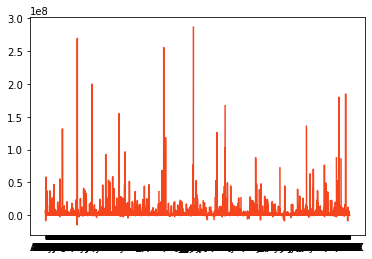

In [872]:
plt.plot(fdf.firm, fdf.bookValue, color='#F5451F')

**It's a bit difficult to see, as we have many firms, but this is how it looks like by firm. If we would like a better histogram we can do it by industry, then probablu we could get information easier to analize.** 

**Then we'll get the Book Value by industry:**


In [874]:
#book value value formula at industry dataframe
idf['bookValue'] = idf['totalassets'] - idf['totalliabilities']
idf[['Sector NAICS\nlevel 1','bookValue']].sort_values(by='bookValue',ascending=False)

,Sector NAICS\nlevel 1,bookValue
7,Finance and Insurance,3.635015e+09
10,Manufacturing,3.449484e+09
9,Information,1.036435e+09
17,Utilities,5.432704e+08
13,"Professional, Scientific, and Technical Services",5.028128e+08
15,Retail Trade,5.002175e+08
2,Administrative and Support and Waste Managemen...,3.496151e+08
11,"Mining, Quarrying, and Oil and Gas Extraction",3.245564e+08
16,Transportation and Warehousing,2.334237e+08
14,Real Estate and Rental and Leasing,1.180439e+08


**If we plot it, it would look like this:**


<BarContainer object of 19 artists>

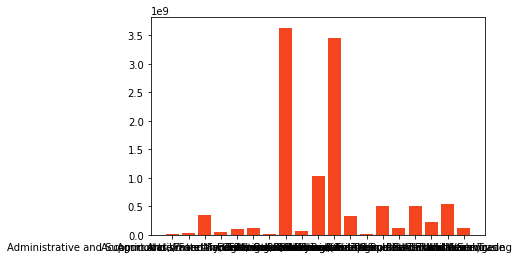

In [875]:
#Plot book value by industry 
plt.bar(idf['Sector NAICS\nlevel 1'], idf.bookValue, color='#F5451F')

**Even tho there are much less industries, is still a little bit difficult to interpret, but by the dataframe sorted, we can see that *Finance and Insurance, Manufacturing	and Information* are the top three industries by Book Value**

###Also, we can measure the firm size by getting the market value: 

##### **Market value = (historical stock price  * Number of shares)**

This can be translated as:

##### **Market value = (original price  * shares outstanding)**


Market value by firm

In [876]:
#Market value formula at firm dataframe
fdf['marketValue'] = fdf['originalprice'] * fdf['sharesoutstanding']
fdf[['firm','Name','marketValue']].sort_values(by='marketValue',ascending=False).dropna().head()

,firm,Name,marketValue
8,AAPL,Apple Inc,2.212838e+09
2125,MSFT,Microsoft Corp,1.920840e+09
1399,GOOGL,Alphabet Inc,1.435042e+09
201,AMZN,"Amazon.Com, Inc",1.080624e+09
3218,TSLA,"Tesla, Inc",6.976698e+08


**In terms of market value, we can see that Apple, Microsoft and Google have the top 3**

**To a more general point of view, we can plot it:** 


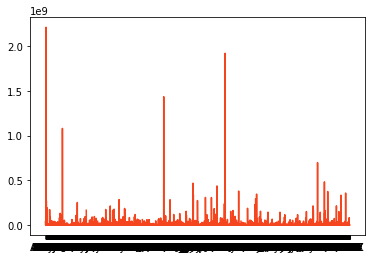

In [877]:
#plotting firms and its market value
plt.plot(fdf.firm, fdf.marketValue, color='#F5451F')

**By industry**

In [880]:
#Market value formula at industry dataframe
idf['marketValue'] = idf['originalprice'] * idf['sharesoutstanding']
idf[['Sector NAICS\nlevel 1','marketValue']].sort_values(by='marketValue',ascending=False).head()

,Sector NAICS\nlevel 1,marketValue
10,Manufacturing,1.438814e+13
7,Finance and Insurance,3.948950e+12
9,Information,1.073203e+12
15,Retail Trade,3.717480e+11
2,Administrative and Support and Waste Managemen...,1.960633e+11


**If we plot this information, it would look like this:**


<BarContainer object of 19 artists>

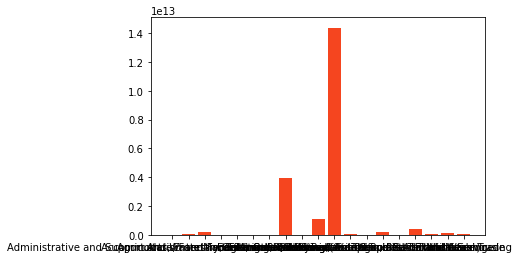

In [837]:
#plotting industries and its market value
plt.bar(idf['Sector NAICS\nlevel 1'], idf.marketValue, color='#F5451F')

**This way to get the size of the firm give us so much information, because it consideres historical stock price and multiplies it by the number of assets. Looking at the results we can see that the bigest industries are Finance and Insurance, Manufacturing and Information**

##**Sales Performance**

The sales performance can be seen by chacking the **sgae** that is the Sales and General Administrative Expenses

In [838]:
#Sales by industry
idf[['Sector NAICS\nlevel 1','sgae']].sort_values(by='sgae',ascending=False).head()

,Sector NAICS\nlevel 1,sgae
10,Manufacturing,3.298824e+08
7,Finance and Insurance,2.361415e+08
15,Retail Trade,1.607004e+08
9,Information,1.397088e+08
16,Transportation and Warehousing,1.177326e+08


<BarContainer object of 19 artists>

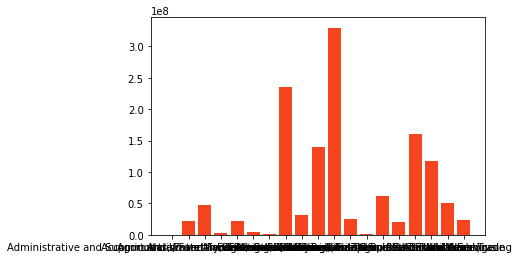

In [839]:
#Plot sales by industry
plt.bar(idf['Sector NAICS\nlevel 1'], idf.sgae, color='#F5451F')

**We can observe a big difference between industries sales. Thanks to the histogram, we can see a big difference between the top 3 and the rest of the industries. In this section it's also shown that the industries that sells the most are "Transportation and Warehousing Arts, Entertainment, and Recreation and Retail Trade"**

**Now, let's do the seme by firm**

In [840]:
#Sales by firm
fdf[['firm','Name','sgae','Sector NAICS\nlevel 1']].sort_values(by='sgae',ascending=False).dropna().head()

,firm,Name,sgae,Sector NAICS\nlevel 1
201,AMZN,"Amazon.Com, Inc",51403000.0,Retail Trade
3495,WMT,Walmart Inc,29404000.0,Retail Trade
1201,FDX,Fedex Corp,22470000.0,Transportation and Warehousing
3307,UPS,"United Parcel Service, Inc",21231000.0,Transportation and Warehousing
1399,GOOGL,Alphabet Inc,20128000.0,"Professional, Scientific, and Technical Services"


<BarContainer object of 3600 artists>

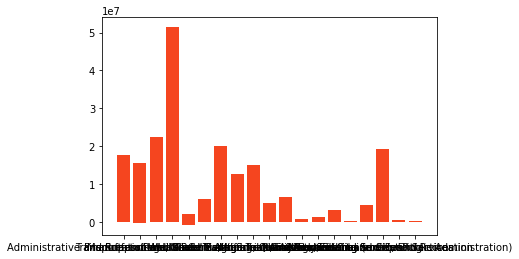

In [841]:
#Plot sales by firm
plt.bar(fdf['Sector NAICS\nlevel 1'], fdf.sgae, color='#F5451F')

**Amazingly, by firm we can see that Amazon is the biggest seller firm, what could explain the retail trade position of the firm, it is a huge difference in Amazon sales compared to the rest. In second place we have Walmart, and in third place it's Fedex. Being the top 3 sellers in USA. Amazingly Google is placed in 5th place, even tho has amazing results in size**

##Profitability

The fromula to get the Profit Margin Measures is by getting the Operating profit margin. 
The formula to get it is: 

**Operating profit margin = ebit/revenue**

And to get the ebit (Earnings before Interest and Taxes) also known as Operating profit, we will use the following formula:

**ebit = revenue - cogs - sgae - otheropexp**



In [842]:
#First we will get the firm ebit
fdf['ebit'] = fdf.revenue - fdf.cogs - fdf.sgae - fdf.otheropexp
fdf[['firm','Name','ebit']].sort_values(by='ebit',ascending=False).dropna().head()

,firm,Name,ebit
8,AAPL,Apple Inc,23076000.0
3550,XOM,Exxon Mobil Corp,20831000.0
2125,MSFT,Microsoft Corp,20534000.0
1399,GOOGL,Alphabet Inc,19453000.0
871,CVX,Chevron Corp,16119000.0


In [843]:
#Then we will get the industry ebit
idf['ebit'] = idf.revenue - idf.cogs - idf.sgae - idf.otheropexp
idf[['Sector NAICS\nlevel 1','ebit']].sort_values(by='ebit',ascending=False).dropna().head()

,Sector NAICS\nlevel 1,ebit
10,Manufacturing,2.662130e+08
7,Finance and Insurance,1.716760e+08
9,Information,5.164214e+07
11,"Mining, Quarrying, and Oil and Gas Extraction",4.406719e+07
15,Retail Trade,4.110833e+07


**Having this, we procedded to get the Profit Margin Measures**

In [844]:
#First by industry:
idf['ipmm'] = idf.ebit / idf.revenue
idf[['Sector NAICS\nlevel 1','ipmm']].sort_values(by='ipmm',ascending=False).dropna().head()

,Sector NAICS\nlevel 1,ipmm
0,-,0.463653
11,"Mining, Quarrying, and Oil and Gas Extraction",0.370305
7,Finance and Insurance,0.267929
13,"Professional, Scientific, and Technical Services",0.186260
1,Accommodation and Food Services,0.183721


<BarContainer object of 19 artists>

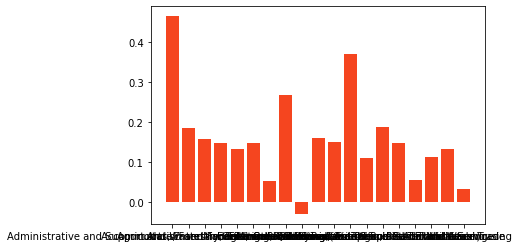

In [845]:
plt.bar(idf['Sector NAICS\nlevel 1'], idf.ipmm, color='#F5451F')

**Here, we can see that the inductries that have more profits are 'Mining, Quarrying, and Oil and Gas Extraction, Finance and Insurance, Professional, Scientific, and Technical Services	Accommodation and Food Services' This could be because producing this kind of industries is not that expensive and some things sell so high. Another point of view is that they are mostly servicess, so clients pay even when they don't use it like insurance**

**In this part we don't see many of the previous industries we have seen in sells or size**

In [846]:
#Then by firm:
fdf['ipmm'] = fdf.ebit / fdf.revenue
fdf[['firm','Name','ipmm', 'Sector NAICS\nlevel 1']].sort_values(by='ipmm',ascending=False).dropna().head()

,firm,Name,ipmm,Sector NAICS\nlevel 1
585,CBIO,"Catalyst Biosciences, Inc",inf,Manufacturing
650,CGEM,"Cullinan Oncology, Inc",inf,Manufacturing
1216,FGF,"Fg Financial Group, Inc",7.453061,Finance and Insurance
3372,VIR,"Vir Biotechnology, Inc",5.543380,Manufacturing
70,AEL,American Equity Investment Life Holding Co,3.829672,Finance and Insurance


**Most firms are Manufacturing and Finance**

###Why some firms are more profitable than others? Which factors/variables from financial statements are related to stock returns?

**First of all, I would like to order the info that is already clean based on the industry**

In [848]:
#Top 5 book value by industry
idf[['Sector NAICS\nlevel 1','bookValue']].sort_values(by='bookValue',ascending=False).head()

,Sector NAICS\nlevel 1,bookValue
7,Finance and Insurance,3.635015e+09
10,Manufacturing,3.449484e+09
9,Information,1.036435e+09
17,Utilities,5.432704e+08
13,"Professional, Scientific, and Technical Services",5.028128e+08


In [849]:
#Top 5 market value by industry
idf[['Sector NAICS\nlevel 1','marketValue']].sort_values(by='marketValue',ascending=False).head()

,Sector NAICS\nlevel 1,marketValue
10,Manufacturing,1.438814e+13
7,Finance and Insurance,3.948950e+12
9,Information,1.073203e+12
15,Retail Trade,3.717480e+11
2,Administrative and Support and Waste Managemen...,1.960633e+11


**As we can see, the most profitable indusrty, talking about book value and market value is the Utilities industy, as it has the biggest profits. Then we have the information industry, that even when is the last one in the top 5 of book value, we can see that also appears in the market value. Making it one of the only two that repeats this pattern.**

**Now, let's do the same, but now analizing the firms:**

In [850]:
#Top 5 book value by firm
fdf[['firm','Sector NAICS\nlevel 1','bookValue']].sort_values(by='bookValue',ascending=False).head()

,firm,Sector NAICS\nlevel 1,bookValue
1750,JPM,Finance and Insurance,286143000.0
377,BAC,Finance and Insurance,269118000.0
1399,GOOGL,"Professional, Scientific, and Technical Services",255419000.0
552,C,Finance and Insurance,199626000.0
3550,XOM,Manufacturing,184508000.0


In [851]:
#Top 5 market value by firm
fdf[['firm','Sector NAICS\nlevel 1','marketValue']].sort_values(by='marketValue',ascending=False).head()

,firm,Sector NAICS\nlevel 1,marketValue
8,AAPL,Manufacturing,2.212838e+09
2125,MSFT,Information,1.920840e+09
1399,GOOGL,"Professional, Scientific, and Technical Services",1.435042e+09
201,AMZN,Retail Trade,1.080624e+09
3218,TSLA,Manufacturing,6.976698e+08


**It is amazing how the same firm, can have different results in book value and market value, making it less profitable, or more profitable. In this case, the only firm that seems to know how to balance is GOOGLE, because results shows it in the 3rd place at book and market value**

**As we can see, the firms with the highest market value are Apple, Microsoft and Google** 

###Show how many firms by industry there are in the sample

In [884]:
#Getting firms by industry
fbi = fdf[['firm','Sector NAICS\nlevel 1']].groupby(by=['Sector NAICS\nlevel 1']).count().reset_index()
fbi

,Sector NAICS\nlevel 1,firm
0,-,2
1,Accommodation and Food Services,69
2,Administrative and Support and Waste Managemen...,133
3,"Agriculture, Forestry, Fishing and Hunting",16
4,"Arts, Entertainment, and Recreation",21
5,Construction,45
6,Educational Services,14
7,Finance and Insurance,701
8,Health Care and Social Assistance,64
9,Information,261


**With this code we can see how many firms are by industry**

##For each industry (and for all industries), what can you say about the typical firm size in terms of market value and book value? How much these variables change within each industry? How firm size (in market value) is distributed?

**To answer this question I wouls like to plot the results ordered, so we can have a better look of how industries and firms are distributed**

**First, we will start wit the Book value:**

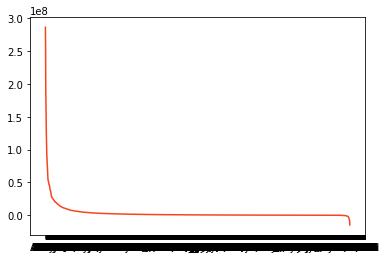

In [889]:
#Firm book value ordered plot
plt.plot(fdf.firm, fdf[['bookValue']].sort_values(by='bookValue',ascending=False), color='#F5451F')

**I decided to plot it by ascending values, to see if we can get a normal distrubution but it seems that we have fewer of the firms at the begining with really big book values. And most of the book values are found between 0 and 0.5le8**

<BarContainer object of 19 artists>

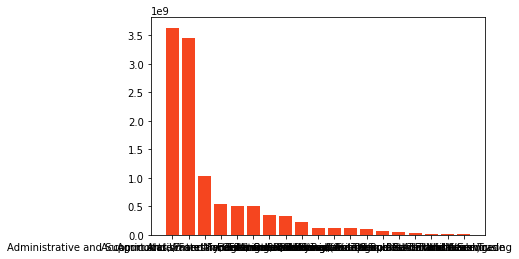

In [909]:
#Industry book value ordered plot
plt.bar(idf['Sector NAICS\nlevel 1'], idf['bookValue'].sort_values(ascending=False), color='#F5451F')

**We have this same distribution when we do it with industries**

**Now let's do the same with market value:**

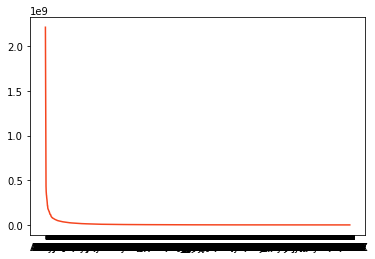

In [910]:
#Firm market value ordered plot
plt.plot(fdf.firm, fdf[['marketValue']].sort_values(by='marketValue',ascending=False), color='#F5451F')

**Again we have a distribution skewed to the left, and most of the rest are between 0 and 0.5le9**

<BarContainer object of 19 artists>

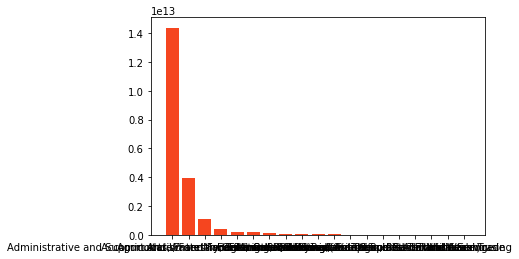

In [911]:
#Industry book value ordered plot
plt.bar(idf['Sector NAICS\nlevel 1'], idf['marketValue'].sort_values(ascending=False), color='#F5451F')

**And also by industry it seems to be less industries that are high valued and it seems to have a distribution skewed to the left too. But many inustries seem to be empty, this migh be because its market value must be really small so we can't really see it in the plot**

##For each industry (and for all industries), what can you say about profit margin of firms? show a) descriptive statistics of profit margin and b) plot(s) to illustrate how profit margin changes across industries.

**A)The descriptive statistics of profit margin**

**By industry:**

In [915]:
#Ebits
fdf['ebit'] = fdf.revenue - fdf.cogs - fdf.sgae - fdf.otheropexp
idf['ebit'] = idf.revenue - idf.cogs - idf.sgae - idf.otheropexp

In [920]:
#First by industry:
idf['ipmm'] = idf.ebit / idf.revenue
idf[['Sector NAICS\nlevel 1','ipmm']]

,Sector NAICS\nlevel 1,ipmm
0,-,0.463653
1,Accommodation and Food Services,0.183721
2,Administrative and Support and Waste Managemen...,0.156790
3,"Agriculture, Forestry, Fishing and Hunting",0.147979
4,"Arts, Entertainment, and Recreation",0.132095
5,Construction,0.146896
6,Educational Services,0.052190
7,Finance and Insurance,0.267929
8,Health Care and Social Assistance,-0.030020
9,Information,0.159758


**By firm**

In [919]:
#Then by firm:
fdf['ipmm'] = fdf.ebit / fdf.revenue
fdf[['firm','Name','ipmm', 'Sector NAICS\nlevel 1']]

,firm,Name,ipmm,Sector NAICS\nlevel 1
0,A,"Agilent Technologies, Inc",0.224020,Manufacturing
1,AA,Alcoa Corp,0.200878,Manufacturing
2,AAIC,Arlington Asset Investment Corp,0.415229,Finance and Insurance
3,AAL,American Airlines Group Inc,0.075771,Transportation and Warehousing
4,AAME,Atlantic American Corp,-0.047348,Finance and Insurance
...,...,...,...,...
3595,ZVIA,Zevia Pbc,-0.323723,Manufacturing
3596,ZVO,Zovio Inc,-0.016368,Educational Services
3597,ZWS,Zurn Elkay Water Solutions Corp,0.188248,Manufacturing
3598,ZY,Zymergen Inc,-40.317388,"Professional, Scientific, and Technical Services"


**b) plot(s) to illustrate how profit margin changes across industries**

**As we already made an analysis of Profit margin, the best way to see how they distribute is making a plot too**

By industry

<BarContainer object of 19 artists>

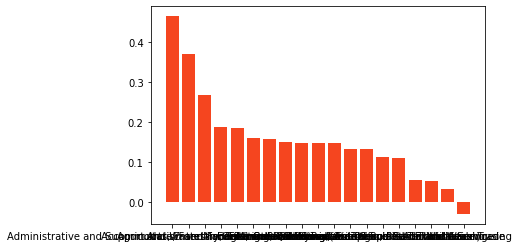

In [922]:
#Profits by industry
plt.bar(idf['Sector NAICS\nlevel 1'], idf['ipmm'].sort_values(ascending=False), color='#F5451F')

**And now we can see that we have a better distribution. It is skewed to the left, but there is no much variance as in the others. Most of the values are found in the middle, between 0.1 and 0.2**

##Which are the biggest 10 US firms in terms of market value and how far they are from the typical size of a US firm?

**Let's get the market values by firm, order them by size, and then get the mean of market value, and see the difference:**

In [971]:
#Top 10 market value by firm
fdf['mn'] = fdf['marketValue'].mean()
fdf['difference'] = fdf['marketValue'] - fdf['mn']
ttmv = fdf[['firm','Name','marketValue','mn','difference']].sort_values(by='marketValue',ascending=False).head(10)
ttmv

,firm,Name,marketValue,mn,difference
8,AAPL,Apple Inc,2.212838e+09,1.095980e+07,2.201878e+09
2125,MSFT,Microsoft Corp,1.920840e+09,1.095980e+07,1.909880e+09
1399,GOOGL,Alphabet Inc,1.435042e+09,1.095980e+07,1.424083e+09
201,AMZN,"Amazon.Com, Inc",1.080624e+09,1.095980e+07,1.069664e+09
3218,TSLA,"Tesla, Inc",6.976698e+08,1.095980e+07,6.867100e+08
3299,UNH,Unitedhealth Group Inc,4.818731e+08,1.095980e+07,4.709133e+08
1744,JNJ,Johnson & Johnson,4.671001e+08,1.095980e+07,4.561403e+08
2029,META,"Meta Platforms, Inc",4.363946e+08,1.095980e+07,4.254348e+08
2285,NVDA,Nvidia Corp,3.789750e+08,1.095980e+07,3.680152e+08
3338,V,Visa Inc,3.743426e+08,1.095980e+07,3.633828e+08


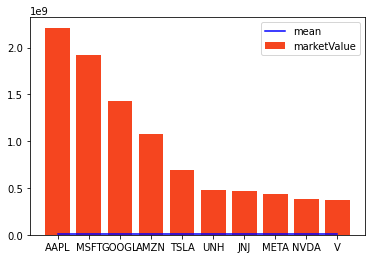

In [979]:
from pyparsing import alphas
plt.plot(ttmv['firm'],ttmv.mn,color="blue")
plt.bar(ttmv['firm'],ttmv.marketValue,color="#F5451F")
plt.legend(['mean', 'marketValue'])

**I thik that by plotting them, we can get a better interpretation of how far are industries from the mean (the mean is shown with a blue line), therefore we can see that all of them are above the media for a lot**

##Which are the biggest 10 US firms in terms of book value and how far they are from the typical size of a US firm?



In [975]:
#Top 10 book value by firm
fdf['mn'] = fdf['bookValue'].mean()
fdf['difference'] = fdf['bookValue'] - fdf['mn']
ttbv = fdf[['firm','Name','marketValue','mn','difference']].sort_values(by='marketValue',ascending=False).head(10)
ttbv

,firm,Name,marketValue,mn,difference
8,AAPL,Apple Inc,2.212838e+09,3.331749e+06,5.477525e+07
2125,MSFT,Microsoft Corp,1.920840e+09,3.331749e+06,1.632103e+08
1399,GOOGL,Alphabet Inc,1.435042e+09,3.331749e+06,2.520873e+08
201,AMZN,"Amazon.Com, Inc",1.080624e+09,3.331749e+06,1.280703e+08
3218,TSLA,"Tesla, Inc",6.976698e+08,3.331749e+06,3.390525e+07
3299,UNH,Unitedhealth Group Inc,4.818731e+08,3.331749e+06,7.287325e+07
1744,JNJ,Johnson & Johnson,4.671001e+08,3.331749e+06,7.302525e+07
2029,META,"Meta Platforms, Inc",4.363946e+08,3.331749e+06,1.224353e+08
2285,NVDA,Nvidia Corp,3.789750e+08,3.331749e+06,2.298825e+07
3338,V,Visa Inc,3.743426e+08,3.331749e+06,3.215125e+07


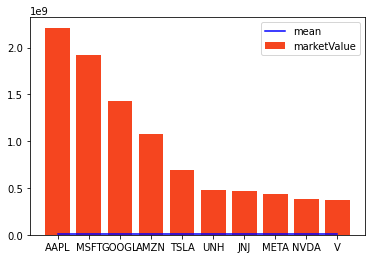

In [978]:
plt.plot(ttbv['firm'],ttbv.mn,color="blue")
plt.bar(ttbv['firm'],ttbv.marketValue,color="#F5451F")
plt.legend(['mean', 'marketValue'])

**We can see that all the top 10 of firms are above the media**